In [2]:
import pandas as pd
import pandahouse as ph
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime

## Ответим на ряд первичных вопросов 

#### Загрузим данные 

In [3]:
connection = {'host': 'http://clickhouse.beslan.pro:8080','database':'simulator','user':'student','password':'dpo_python_2020'}

In [4]:
# Запрос на получение df post_id	views	likes	uniq_users
query = '''
select 
    post_id,
    countIf(action = 'view') as views,
    countIf(action = 'like') as likes,
    uniq(user_id) as uniq_users
from {db}.feed_actions
where toDate(time) > yesterday()-10000
group by post_id
order by views desc
limit 100000
'''

In [5]:
df = ph.read_clickhouse(query, connection=connection)
df

,post_id,views,likes,uniq_users
0,5483,103291,30931,55340
1,5309,93190,28081,52103
2,5237,89493,27137,50224
3,4237,82448,23095,45665
4,4574,79538,21835,45735
...,...,...,...,...
6346,135,1,1,1
6347,9,1,0,1
6348,1015,1,0,1
6349,210,1,0,1


In [7]:
df.sort_values(['post_id'])

,post_id,views,likes,uniq_users
5363,0,213,15,204
4897,1,439,51,414
2298,2,5161,1197,3505
1661,3,8474,2050,4991
5545,4,154,16,151
...,...,...,...,...
6272,6641,12,2,12
2022,6645,6409,1449,5553
5441,6646,191,16,191
5684,6650,116,22,116


#### Оценим медиану и среднее по лайкам

In [8]:
print('Медиана лайков:', df['likes'].median(), 'Среднее лайков:', round(df['likes'].mean(),2))
print('Медиана просм.:', df['views'].median(), 'Среднее просм.:', round(df['views'].mean(),2))

Медиана лайков: 304.0 Среднее лайков: 1525.7
Медиана просм.: 2550.0 Среднее просм.: 7289.29


#### Построим гисторграммы для лайков и просмотров, q-q график (и боксплоты ради любопытства) для нестандартизованных данных

<AxesSubplot:>

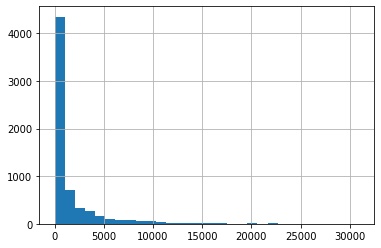

In [9]:
# Гисограмма для НЕстандртзованных лайков
df.likes.hist(bins=30)

<AxesSubplot:>

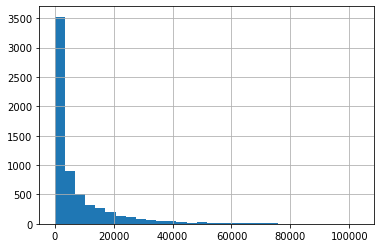

In [10]:
# Гисограмма для НЕстандртзованных просмотров
df.views.hist(bins=30)

/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


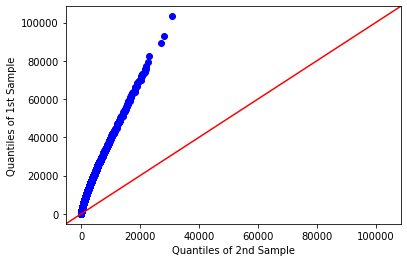

In [12]:
# НЕстандартизованный qq график для двух столбцов
qqplot_2samples(df.views,df.likes, line='45')
plt.show()

/nfs/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='likes'>

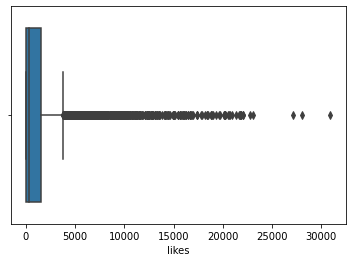

In [13]:
sns.boxplot(df.likes)

/nfs/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='views'>

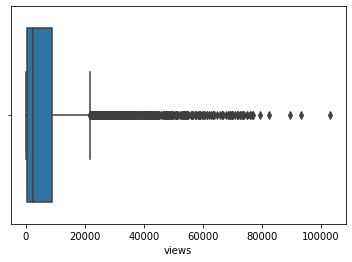

In [14]:
sns.boxplot(df.views)

#### Наблюдаем пики около нуля/единицы как для просмотров, так и для лайков. Для данных характерна положительная асимметрия

#### Стандартизуем данные и сделаем тоже самое для стандартизованых цифр

In [15]:
# Функция для стандартизации данных
def scale_data(data):
    data=np.array(data).reshape(-1,1)
    data=StandardScaler().fit_transform(data)
    data=pd.DataFrame(data)
    return(data)

In [16]:
# Стандартизуем лайки и просмотры
sdl=scale_data(df.likes)
sdv=scale_data(df.views)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

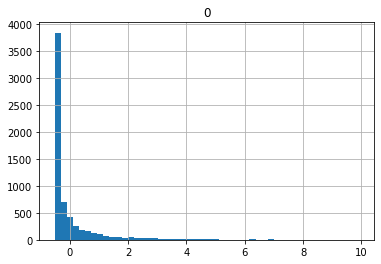

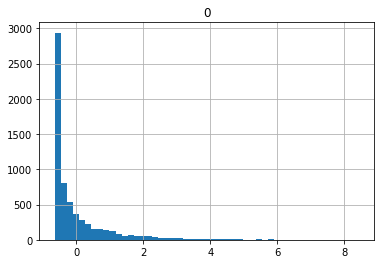

In [17]:
sdl.hist(bins=50)
sdv.hist(bins=50)

/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


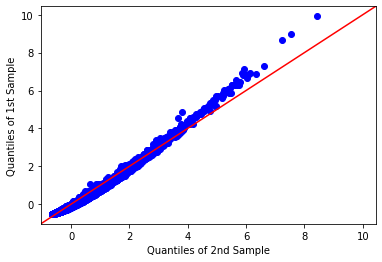

In [18]:
# стандартизованный qq график для двух столбцов
qqplot_2samples(sdl,sdv, line='45')
plt.show()

#### Стандартизированные данные отличаются по своим правым "хвостам" - концам распределений

#### Оценим CTR как отношение лайков к просмотрам, кроме того оценим время жизни каждого поста

In [19]:
# добавим столбец ctr в наш dataframe 
df['ctr']=df.likes/df.views
df.sort_values('post_id', inplace=True)
df

,post_id,views,likes,uniq_users,ctr
5363,0,213,15,204,0.070423
4897,1,439,51,414,0.116173
2298,2,5161,1197,3505,0.231932
1661,3,8474,2050,4991,0.241916
5545,4,154,16,151,0.103896
...,...,...,...,...,...
6272,6641,12,2,12,0.166667
2022,6645,6409,1449,5553,0.226088
5441,6646,191,16,191,0.083770
5684,6650,116,22,116,0.189655


In [20]:
# запросим данные по времени 
query_time = '''
select 
    max(time) as max_time,
    min(time) as min_time,
    post_id
from {db}.feed_actions
group by post_id
order by post_id
'''

In [21]:
data_time = ph.read_clickhouse(query_time, connection=connection)
data_time

,max_time,min_time,post_id
0,2021-10-20 07:35:31,2021-10-19 00:29:50,0
1,2021-10-21 03:25:08,2021-10-19 18:40:17,1
2,2021-10-23 23:57:57,2021-10-19 23:22:23,2
3,2021-10-24 23:46:17,2021-10-19 20:33:29,3
4,2021-10-20 15:36:16,2021-10-19 17:28:45,4
...,...,...,...
6347,2022-01-12 17:07:38,2022-01-12 16:54:01,6641
6348,2022-01-12 17:07:37,2022-01-12 01:39:03,6645
6349,2022-01-12 17:05:38,2022-01-12 13:30:11,6646
6350,2022-01-12 17:07:38,2022-01-12 16:48:11,6650


In [22]:
# вычислим время жизни каждого поста
data_time['delta_time']=data_time.max_time-data_time.min_time
data_time.dtypes

max_time       datetime64[ns]
min_time       datetime64[ns]
post_id                uint32
delta_time    timedelta64[ns]
dtype: object

In [23]:
# добавим в dataframe столбец с временем жизни поста
df['live_time']=data_time['delta_time']
df

,post_id,views,likes,uniq_users,ctr,live_time
5363,0,213,15,204,0.070423,0 days 03:03:29
4897,1,439,51,414,0.116173,3 days 14:59:44
2298,2,5161,1197,3505,0.231932,2 days 12:31:06
1661,3,8474,2050,4991,0.241916,3 days 04:26:28
5545,4,154,16,151,0.103896,0 days 10:30:07
...,...,...,...,...,...,...
6272,6641,12,2,12,0.166667,0 days 18:18:32
2022,6645,6409,1449,5553,0.226088,1 days 16:50:36
5441,6646,191,16,191,0.083770,0 days 15:22:19
5684,6650,116,22,116,0.189655,1 days 11:21:34


<AxesSubplot:>

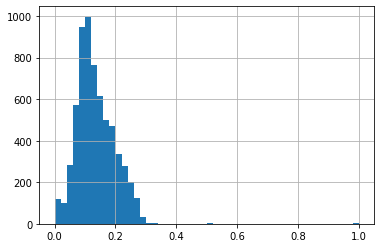

In [24]:
# выведем гистограмму CTR
df.ctr.hist(bins=50)

#### По сравнению с просмотрами и лайками, CTR менее ассиметричен

In [30]:
df['live_time'].dt.total_seconds()/360

5363     30.580556
4897    869.955556
2298    605.183333
1661    764.411111
5545    105.019444
           ...    
6272    183.088889
2022    408.433333
5441    153.719444
5684    353.594444
5535     59.283333
Name: live_time, Length: 6351, dtype: float64

In [32]:
df['live_time_hour']=df['live_time'].dt.total_seconds()/360

<AxesSubplot:>

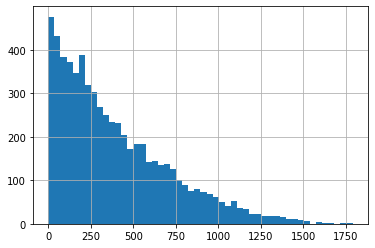

In [33]:
# гистограмма времени жизни поста
df.live_time_hour.hist(bins=50)

In [225]:
# медиана времени жизни поста
df['live_time_hour'].median()

300.45

In [34]:
# среднее времени жизни поста
round(df['live_time_hour'].mean(),2)

392.01

#### Построим матрицу корреляций 

In [232]:
corr_matrix=df[['views','likes','ctr','live_time_hour']].corr()

In [233]:
corr_matrix

,views,likes,ctr,live_time_hour
views,1.000000,0.989809,0.710893,0.025021
likes,0.989809,1.000000,0.673229,0.023500
ctr,0.710893,0.673229,1.000000,0.030349
live_time_hour,0.025021,0.023500,0.030349,1.000000


#### Визуализируем эти взаимосвязи

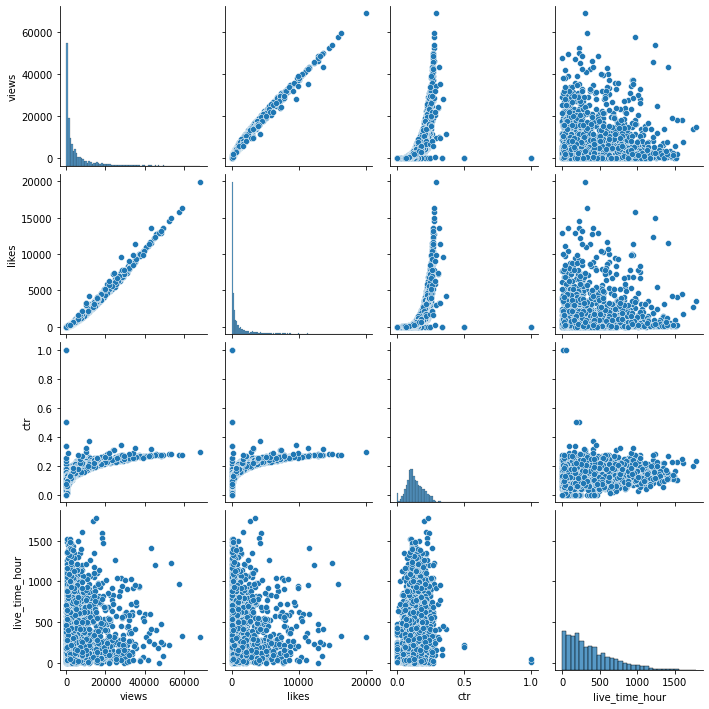

In [234]:
sns.pairplot(df[['views','likes','ctr','live_time_hour']])

#### Мы посмотрели как на вклад пользователей, так и вклад постов в общую динамику просмотров и лайков. Однако не менее полезной может оказаться декомпозиция временного ряда на компоненты - чтобы выделить отдельные составляющие части процесса

#### Возьмем почасовую динамику активности за весь период и проанализируем её функцией statsmodels.tsa.seasonal.STL. 

In [39]:
query_time = '''
SELECT 
    toStartOfInterval(time, INTERVAL 1 hour) as t,
    uniq(user_id) as uu_id
FROM {db}.feed_actions
GROUP BY t 
order by t
'''

In [40]:
data_activ_user = ph.read_clickhouse(query_time, connection=connection)
data_activ_user

,t,uu_id
0,2021-10-19 00:00:00,17
1,2021-10-19 01:00:00,20
2,2021-10-19 02:00:00,15
3,2021-10-19 03:00:00,8
4,2021-10-19 04:00:00,9
...,...,...
2053,2022-01-12 13:00:00,2070
2054,2022-01-12 14:00:00,2151
2055,2022-01-12 15:00:00,2143
2056,2022-01-12 16:00:00,2289


/tmp/ipykernel_148/1054175411.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(data_activ_user.uu_id, model='multiplicative', freq=1)


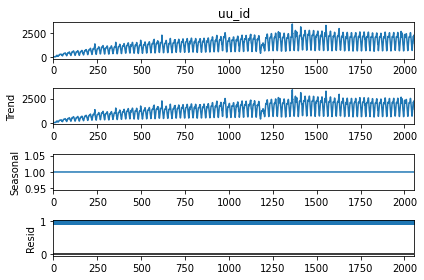

In [41]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_activ_user.uu_id, model='multiplicative', freq=1)
result.plot()
pyplot.show()
